In [ ]:
# Author: Janssen Kotah
# snRNAseq analysis for WT/SHIP1 KO mice as part of Matera et al. project
# harmony integration is based on package vignette: https://portals.broadinstitute.org/harmony/articles/quickstart.html

In [1]:
library(Seurat)
library(dplyr)
library(patchwork)
library(ggplot2)
library(harmony)

sessionInfo()

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/bcn/p310674/anaconda3/envs/R_env/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_0.1.1      Rcpp_1.0.11        ggplot2_3.4.2      patchwork_1.1.2   
[5] dplyr_1.1.2        SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] nlme_3.1-162           spatstat.sparse_3.0-1  matrixStats_1.0.0     
  [4] RcppAnnoy_0.0.20       RColorBrewer

In [1]:
sample_list_seu <- readRDS("002C_listed_samples_after_SoupX_QCprocessed.rds")

scratch.dir <- "./"
Output.dir.plots = "./003A_Harmony_integration/"
Output.dir.objects = paste0(scratch.dir, "003A_")


In [3]:
sample_list <- names(sample_list_seu)
sample_list

[1] "JK1" "JK2" "JK3" "JK4" "JK5" "JK6" "JK7" "JK8"

In [4]:
sample_list_seu

$JK1
An object of class Seurat 
21963 features across 8087 samples within 1 assay 
Active assay: RNA (21963 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

$JK2
An object of class Seurat 
22333 features across 8227 samples within 1 assay 
Active assay: RNA (22333 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

$JK3
An object of class Seurat 
22289 features across 10398 samples within 1 assay 
Active assay: RNA (22289 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

$JK4
An object of class Seurat 
21371 features across 5840 samples within 1 assay 
Active assay: RNA (21371 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

$JK5
An object of class Seurat 
22171 features across 7129 samples within 1 assay 
Active assay: RNA (22171 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

$JK6
An object of class Seurat 
21902 featur

In [5]:
#Merge into one for Harmony
cells = merge(sample_list_seu[[1]], y = c(sample_list_seu[[2]], sample_list_seu[[3]],
                                         sample_list_seu[[4]],sample_list_seu[[5]],
                                          sample_list_seu[[6]],sample_list_seu[[7]],
                                          sample_list_seu[[8]]
                                         ),
              add.cell.ids = sample_list, project = "SHIP1"
             )
cells

An object of class Seurat 
24356 features across 51315 samples within 1 assay 
Active assay: RNA (24356 features, 0 variable features)

In [6]:
DefaultAssay(cells) = "RNA"
nrow(cells@meta.data) %>% print()
cells@meta.data$sample %>% table() %>% print()

[1] 51315
.
  JK1   JK2   JK3   JK4   JK5   JK6   JK7   JK8 
 8087  8227 10398  5840  7129  5816   882  4936 


In [10]:
#check which cells are predicted by Scrublet to be removable
cells$predicted_doublets %>% table()

.
False  True 
50177  1138 

In [11]:
#remove doublets
cells = subset(cells, predicted_doublets == "False")
cells

An object of class Seurat 
24356 features across 50177 samples within 1 assay 
Active assay: RNA (24356 features, 0 variable features)

In [12]:
cells <- NormalizeData(cells, verbose = FALSE)
cells <- FindVariableFeatures(cells, selection.method = "vst",
                              nfeatures = 2000, verbose = FALSE) 

### Add top detected microglial genes in bulk to VariableFeatures for integration

In [13]:
#inspect top microglial genes in variable features
bulk_DEGS = readxl::read_excel("../SHIP1 Full list 3KO vs 4WT_08022023[2].xlsx", sheet = 2)
top75 = bulk_DEGS %>% slice(1:75) %>% .$symbol

VariableFeatures(cells) %in% top75  %>% table()
VariableFeatures(cells)[VariableFeatures(cells) %in% top75]

.
FALSE  TRUE 
 1989    11 

[1] "Siglech"  "Apoe"     "Cst3"     "Sparc"    "Csf1r"    "Tgfbr1"  
 [7] "Slco2b1"  "Golm1"    "Serpine2" "Fcrls"    "Selenop"

In [14]:
VariableFeatures(cells) = c(VariableFeatures(cells), top75) %>% unique()
length(VariableFeatures(cells))

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): CYTB, ND1”


[1] 2062

In [15]:
print("rescaling object")

cells <- ScaleData(object = cells, vars.to.regress = c("percent.mito", "nCount_RNA", "percent.ribo"))


[1] "rescaling object"


Regressing out percent.mito, nCount_RNA, percent.ribo

Centering and scaling data matrix



In [16]:
cells <- RunPCA(cells, #pc.genes = cells@var.genes,
                npcs = 50, verbose = FALSE)

#saveRDS(cells, paste0(Output.dir.objects, "allSamps_harmony_integration.rds")) #save scaled obj for safety



Saving 6.67 x 6.67 in image


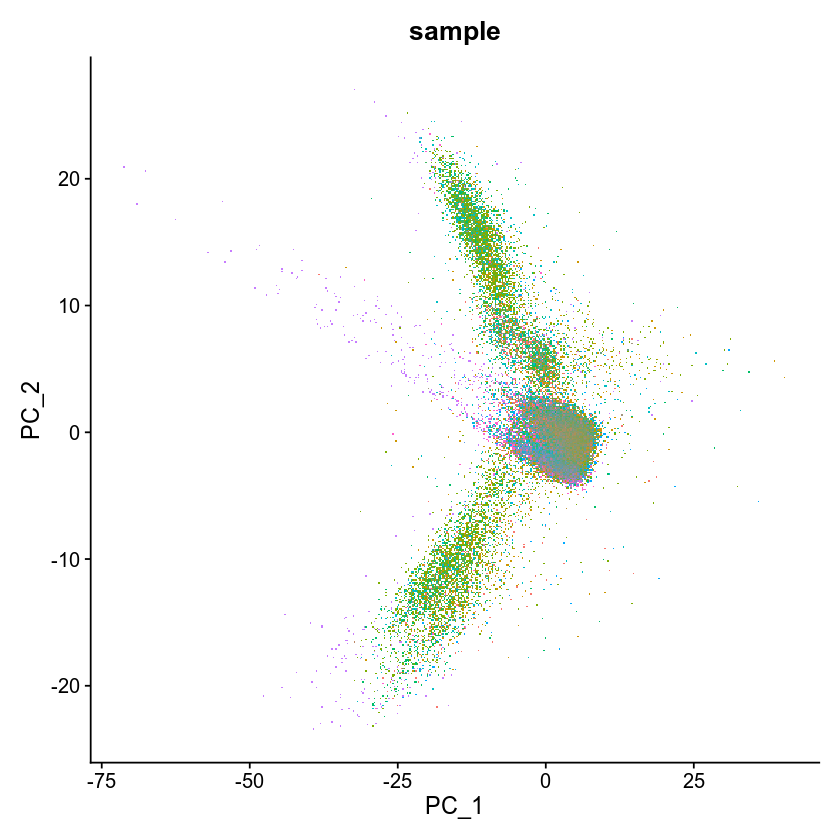

Saving 6.67 x 6.67 in image


[1] "PCs to load into Harmony: 26"


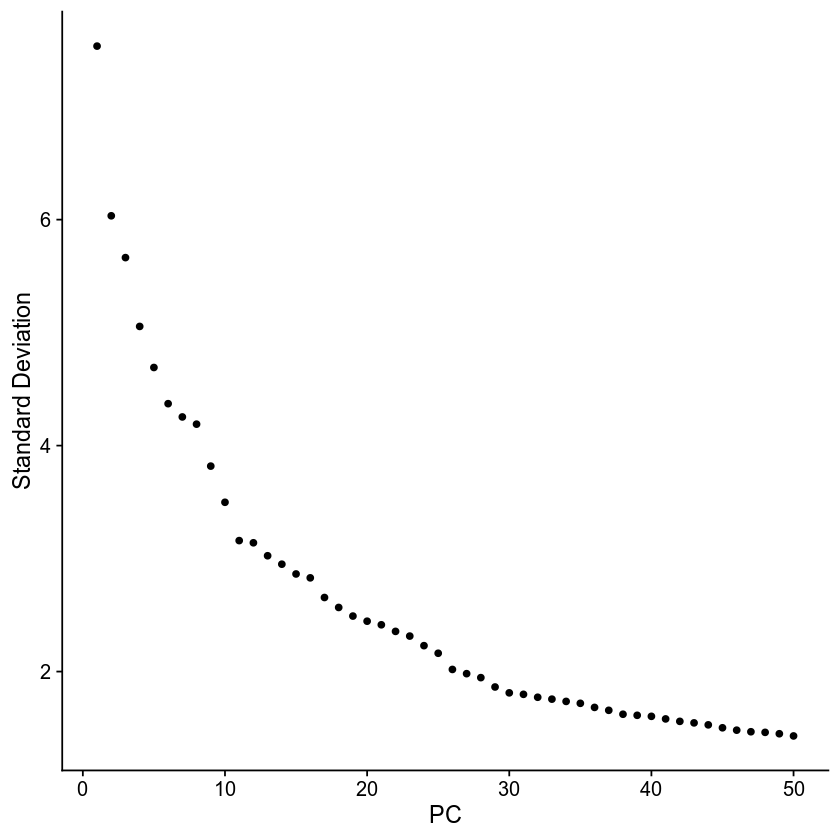

In [17]:
#identify PCs to input
DimPlot(cells, reduction = "pca", group.by = "sample", raster = T) + NoLegend()
ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_scaled_pca.pdf"))
ElbowPlot(cells, ndims = 50)
ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_scaled_elbowPlot.pdf"))

# Determine percent of variation associated with each PC
pct <- cells[["pca"]]@stdev / sum(cells[["pca"]]@stdev) * 100
# Calculate cumulative percents for each PC
cumu <- cumsum(pct)
# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1
pcs_pca <- min(co1, co2)

print(paste0("PCs to load into Harmony: ", pcs_pca))

[1] "starting harmony based on optimal PCs"


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Saving 6.67 x 6.67 in image


[1] "harmony finished, processing object"


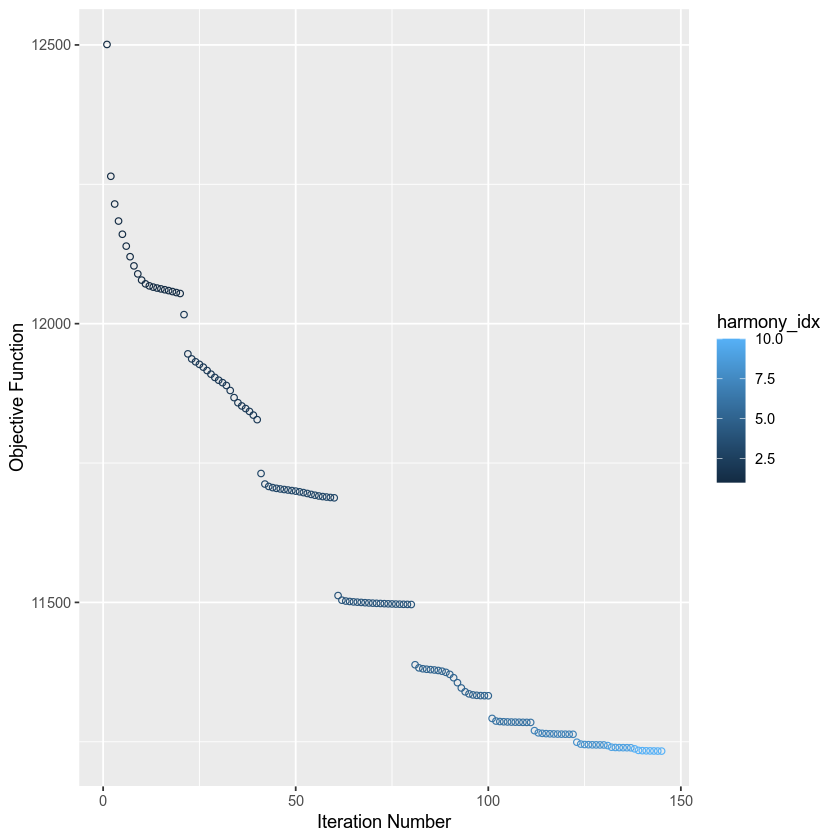

In [18]:
print("starting harmony based on optimal PCs")

cells <- RunHarmony(cells, "sample", plot_convergence = TRUE)

ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_convergencePlot.pdf"))

print("harmony finished, processing object")


In [19]:
#determine optimal PCs to load into UMAP based on proposed method from https://hbctraining.github.io/scRNA-seq/lessons/elbow_plot_metric.html

# Determine percent of variation associated with each PC
pct <- cells[["harmony"]]@stdev / sum(cells[["harmony"]]@stdev) * 100
# Calculate cumulative percents for each PC
cumu <- cumsum(pct)
# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1
pcs_harmony <- min(co1, co2)
print(paste0("Harmony PCs to load into UMAP: ", pcs_harmony))


[1] "Harmony PCs to load into UMAP: 33"


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
00:16:11 UMAP embedding parameters a = 0.9922 b = 1.112

00:16:11 Read 50177 rows and found 33 numeric columns

00:16:11 Using Annoy for neighbor search, n_neighbors = 30

00:16:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:16:18 Writing NN index file to temp file /tmp/RtmpFP8pXI/file21cae152a8f53f

00:16:18 Searching Annoy index using 1 thread, search_k = 3000

00:16:36 Annoy recall = 100%

00:16:37 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50177
Number of edges: 2046950

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9854
Number of communities: 24
Elapsed time: 12 seconds


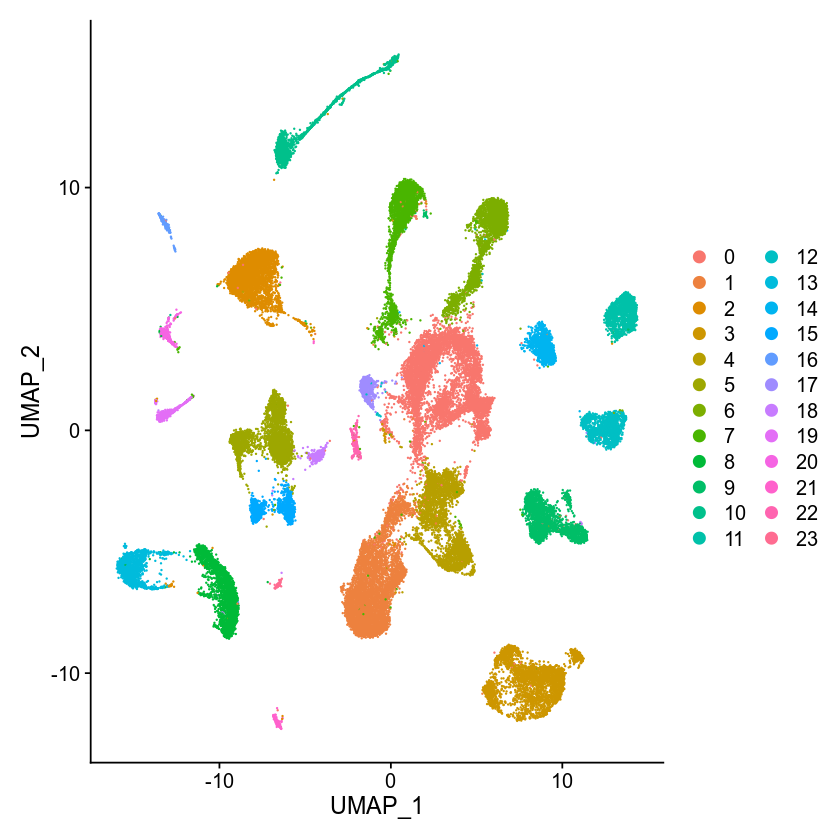

In [20]:
cells = cells %>%
    RunUMAP(reduction = "harmony", dims = 1:pcs_harmony) %>%
    FindNeighbors(reduction = "harmony", dims = 1:pcs_harmony) %>%
    FindClusters(resolution = 0.12) %>%
    identity()

DimPlot(cells)

In [22]:
saveRDS(cells, paste0(Output.dir.objects, "allSamps_harmony_integration.rds"))


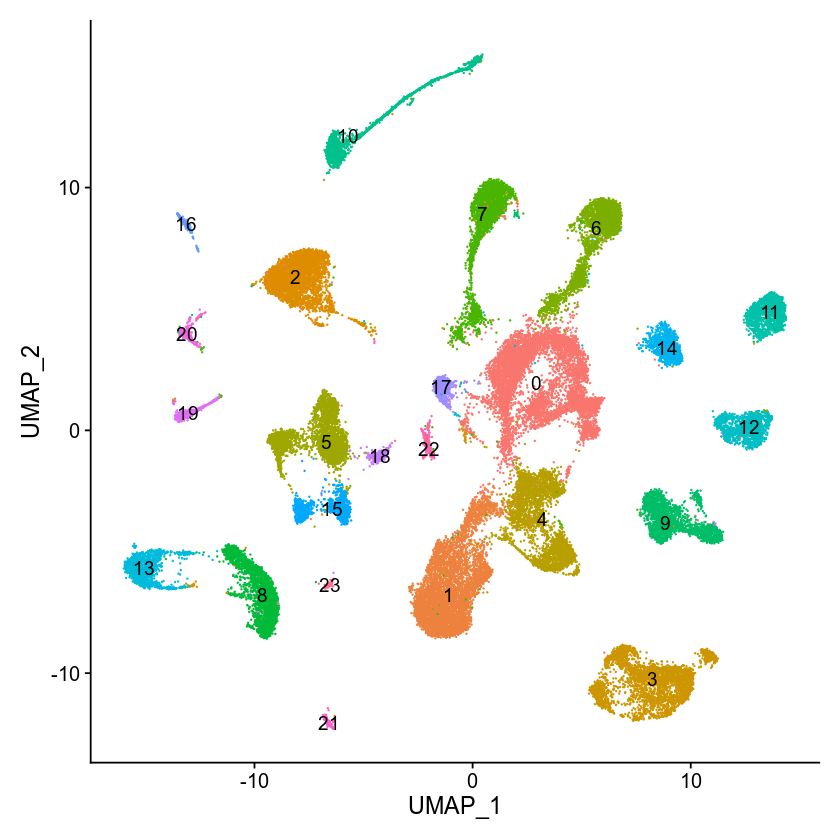

In [29]:
DimPlot(cells, label = T) + NoLegend()

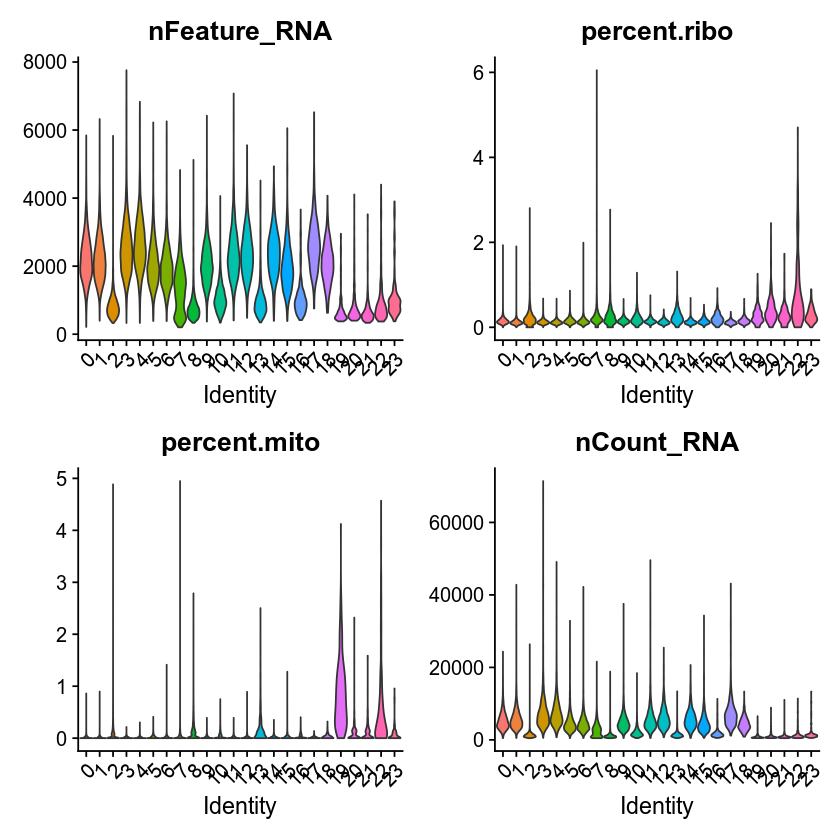

In [23]:
VlnPlot(cells,
        features = c("nFeature_RNA", "percent.ribo", "percent.mito","nCount_RNA"),         
        ncol = 2, pt.size = 0)


In [24]:
cells@meta.data %>% group_by(Genotype) %>% select(RNA_snn_res.0.12) %>% table()


Adding missing grouping variables: `Genotype`


        RNA_snn_res.0.12
Genotype    0    1    2    3    4    5    6    7    8    9   10   11   12   13
      KO 2808 2563 2055 1355 1060 1624  941 1680 1331  901 1165  453  408  703
      WT 4167 3172 1961 2140 2341 1653 2079 1327 1321 1706  882 1043 1047  741
        RNA_snn_res.0.12
Genotype   14   15   16   17   18   19   20   21   22   23
      KO  436  573  303  198  273  263  247  150  136  110
      WT  739  560  262  339  237  227  177  144  155   21

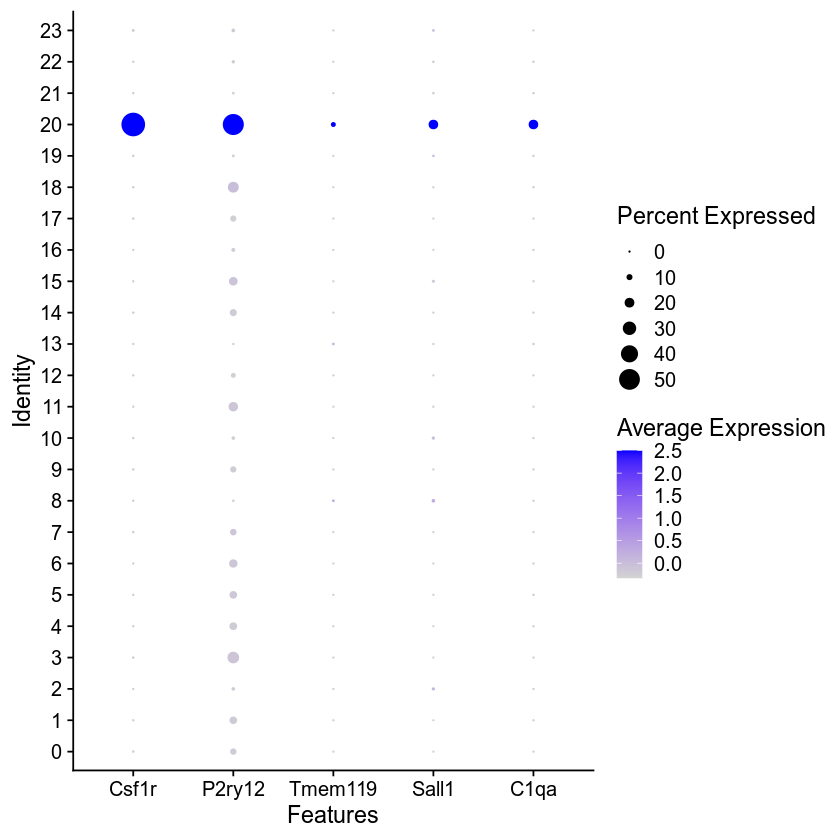

In [25]:
#identify possible microglial cluster
DotPlot(cells, features = c("Csf1r", "P2ry12", "Tmem119", "Sall1", "C1qa"))

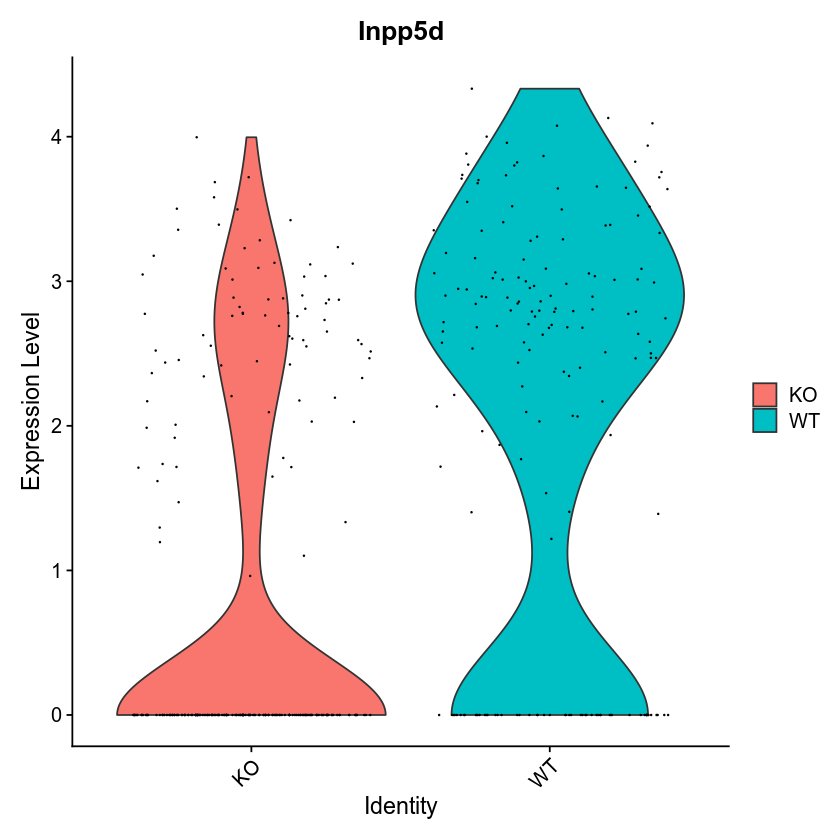

In [26]:
#confirm expected change in SHIP1 due to genotype
VlnPlot(cells, feature = "Inpp5d", group.by = "Genotype", idents = 20)

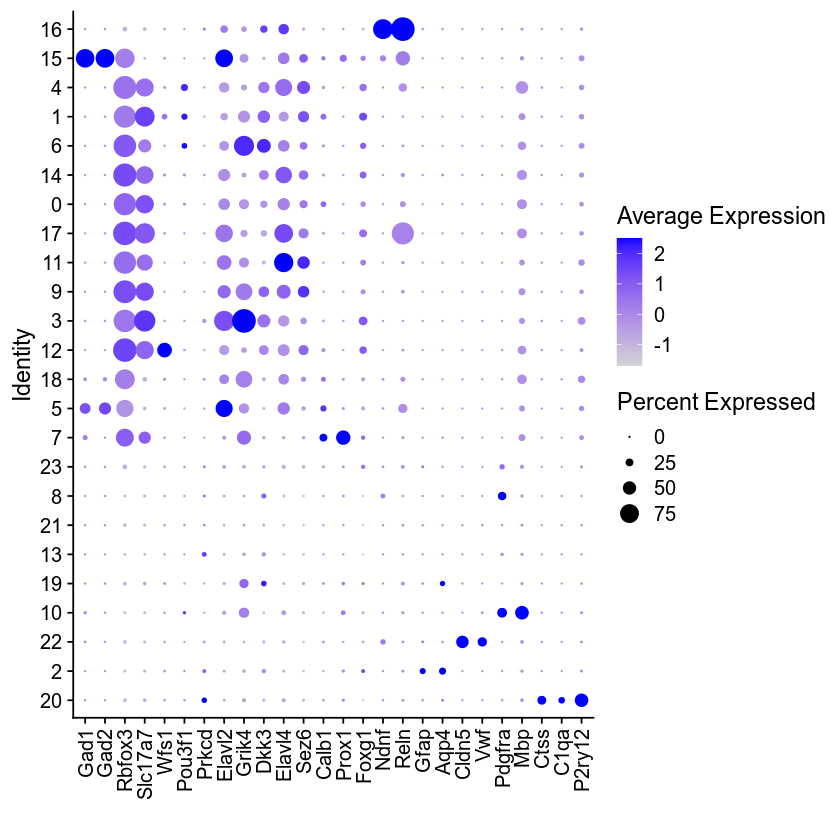

In [28]:
markers = c("Gad1", "Gad2", #interneurons
            "Rbfox3",                        
            "Slc17a7",
            "Wfs1", "Pou3f1", #CA1?
            "Prkcd",
            "Elavl2", "Grik4", "Dkk3",
            "Elavl4", "Sez6",
            "Calb1", "Prox1", #dentate gyrus
            "Foxg1",
            "Ndnf", "Reln", #Cajal-Retzius            
            "Gfap", "Aqp4", #astros
            "Cldn5", "Vwf", #endothelial
            "Pdgfra", "Mbp", #oligos
            "Ctss", "C1qa", "P2ry12"
           )

DotPlot(cells, features = markers, cluster.idents = T)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust =1)) + xlab("")


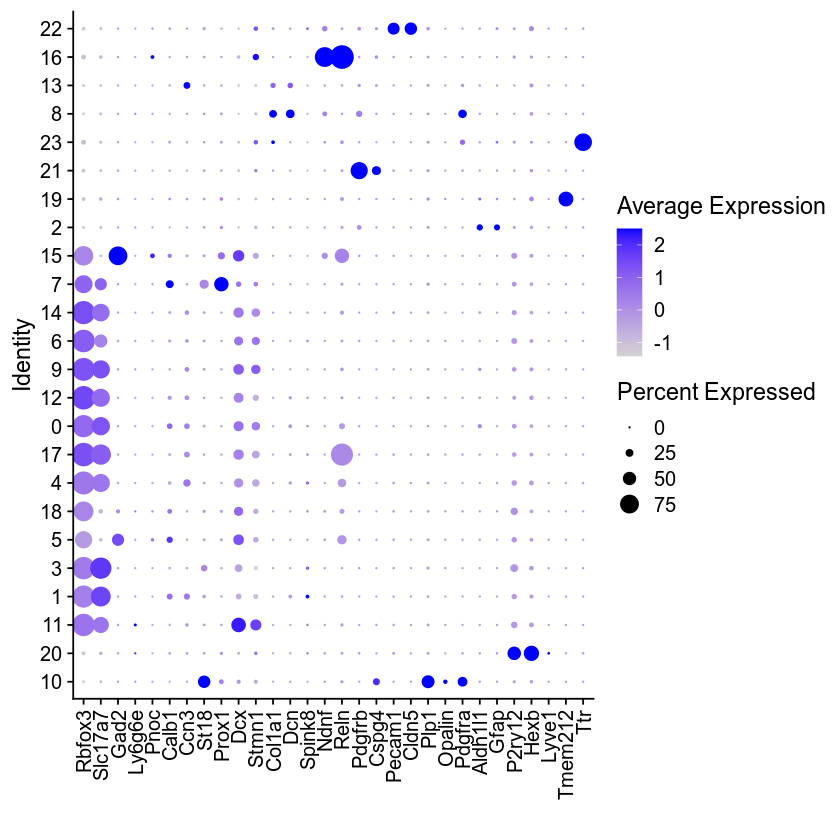

In [27]:
markers1 = c("Rbfox3", #neurons
           "Slc17a7", "Gad2",#    "Pcp4",
           "Ly6g6e",           
           "Pnoc", #interneurons?           
           "Calb1","Ccn3",
           "St18", "Prox1", #DG cells
           "Dcx",
           "Stmn1",
           "Col1a1", "Dcn", #fibroblast
           "Spink8", #hippocampal pyramidal cells
           "Ndnf", "Reln", #Cajal-retzius cells
           "Pdgfrb","Cspg4", #mural cells
           "Pecam1", "Cldn5", #endothelial
           "Plp1", "Opalin", "Pdgfra", #oligo
           "Aldh1l1","Gfap", #astros
           "P2ry12", "Hexb", "Lyve1", #microglia
           "Tmem212", "Ttr" #ependymal/choroid
          )

DotPlot(cells, features = markers1, cluster.idents = T)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust =1)) + xlab("")


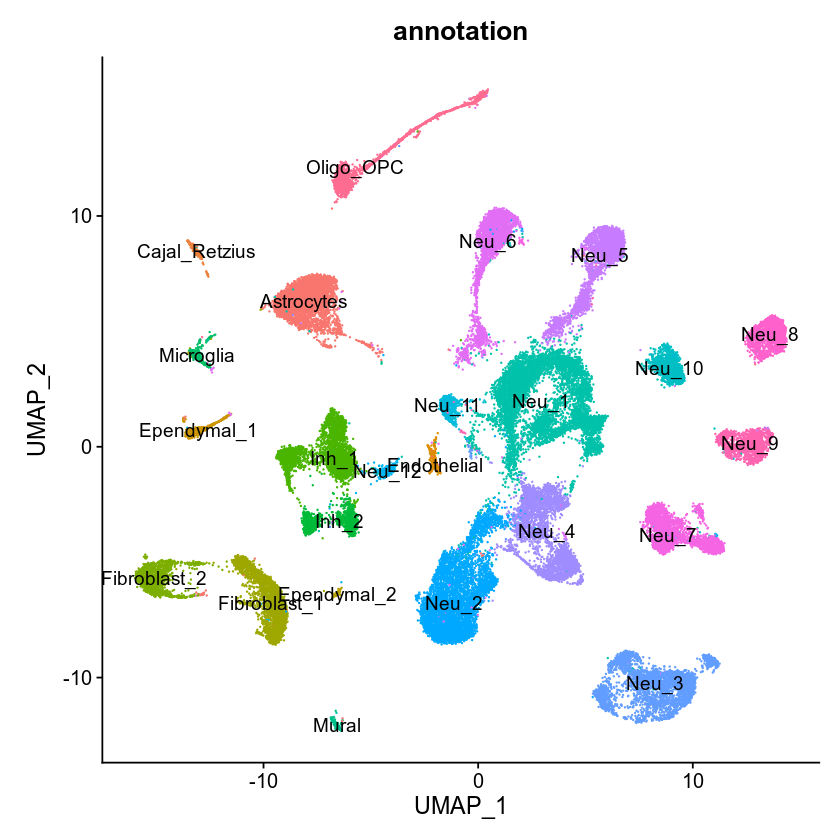

In [30]:
#tentative annotation based on prev preliminary analysis (check markers to confirm)
cells$annotation = case_when(cells$RNA_snn_res.0.12 == 0 ~ "Neu_1", 
                             cells$RNA_snn_res.0.12 == 1 ~ "Neu_2", 
                             cells$RNA_snn_res.0.12 == 2 ~ "Astrocytes", 
                             cells$RNA_snn_res.0.12 == 3 ~ "Neu_3", 
                             cells$RNA_snn_res.0.12 == 4 ~ "Neu_4", 
                             cells$RNA_snn_res.0.12 == 5 ~ "Inh_1", 
                             cells$RNA_snn_res.0.12 == 6 ~ "Neu_5", 
                             cells$RNA_snn_res.0.12 == 7 ~ "Neu_6", 
                             cells$RNA_snn_res.0.12 == 8 ~ "Fibroblast_1", 
                             cells$RNA_snn_res.0.12 == 9 ~ "Neu_7", 
                             cells$RNA_snn_res.0.12 == 10 ~ "Oligo_OPC", 
                             cells$RNA_snn_res.0.12 == 11 ~ "Neu_8", 
                             cells$RNA_snn_res.0.12 == 12 ~ "Neu_9", 
                             cells$RNA_snn_res.0.12 == 13 ~ "Fibroblast_2",
                             cells$RNA_snn_res.0.12 == 14 ~ "Neu_10",
                             cells$RNA_snn_res.0.12 == 15 ~ "Inh_2",
                             cells$RNA_snn_res.0.12 == 16 ~ "Cajal_Retzius",
                             cells$RNA_snn_res.0.12 == 17 ~ "Neu_11",
                             cells$RNA_snn_res.0.12 == 18 ~ "Neu_12",
                             cells$RNA_snn_res.0.12 == 19 ~ "Ependymal_1",
                             cells$RNA_snn_res.0.12 == 20 ~ "Microglia",
                             cells$RNA_snn_res.0.12 == 21 ~ "Mural",
                             cells$RNA_snn_res.0.12 == 22 ~ "Endothelial",
                             cells$RNA_snn_res.0.12 == 23 ~ "Ependymal_2"
                             
                             
                            )

DimPlot(cells, group.by = "annotation", label =T) +NoLegend()

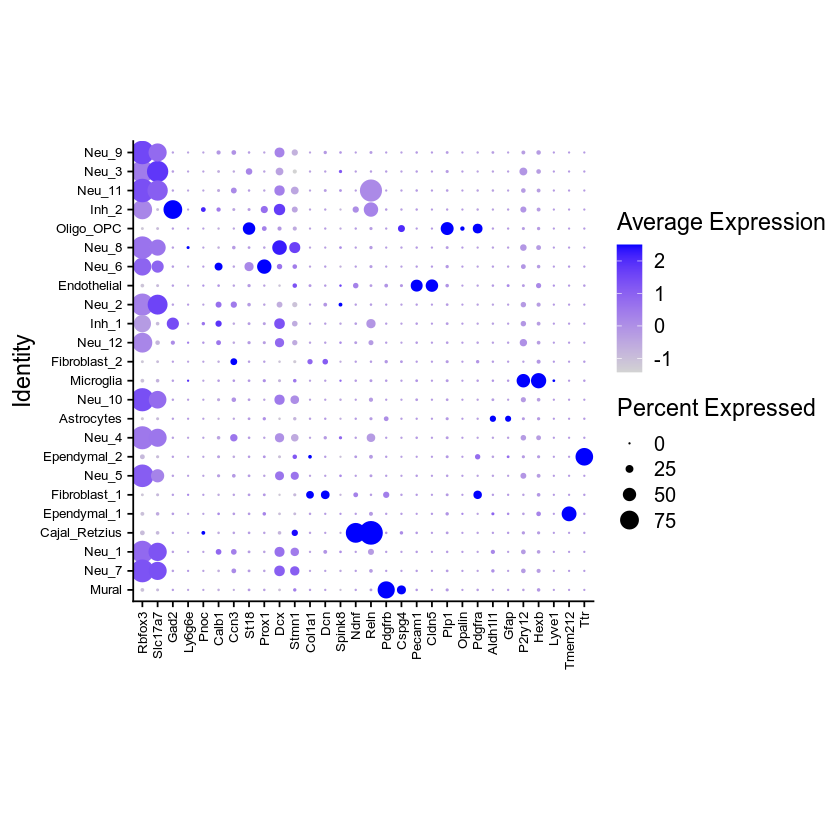

In [31]:
DotPlot(cells, features = markers1, group.by = "annotation",
        cluster.idents = T)+ theme(axis.text.x = element_text(size = 8, angle = 90, vjust = 0.5, hjust =1),
                                   axis.text.y = element_text(size = 8),
                                  aspect.ratio = 8/8) + xlab("")


Adding missing grouping variables: `sample`


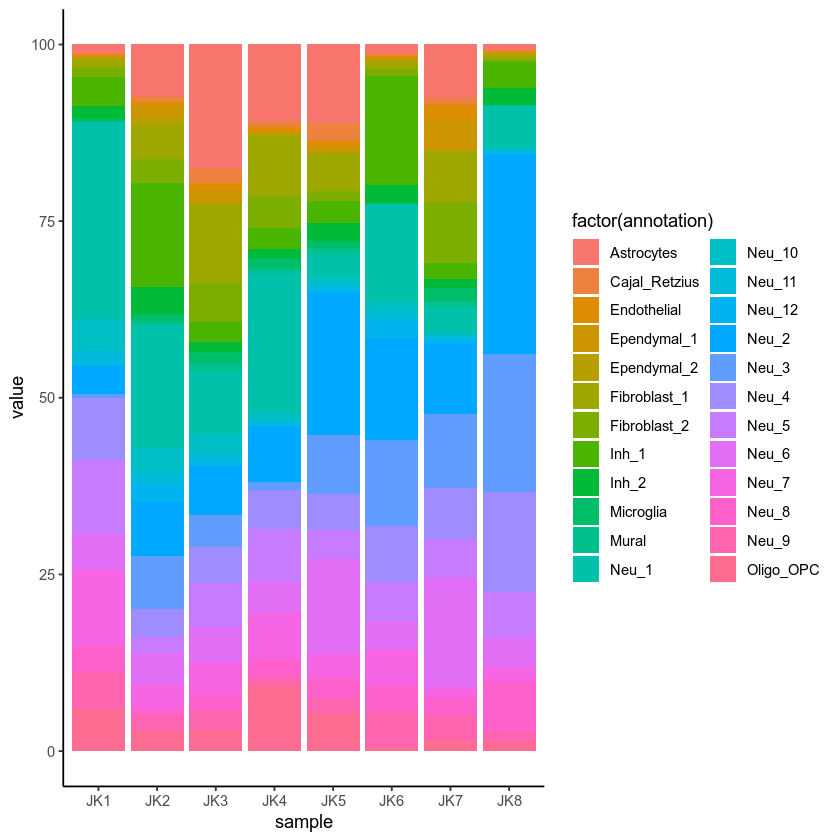

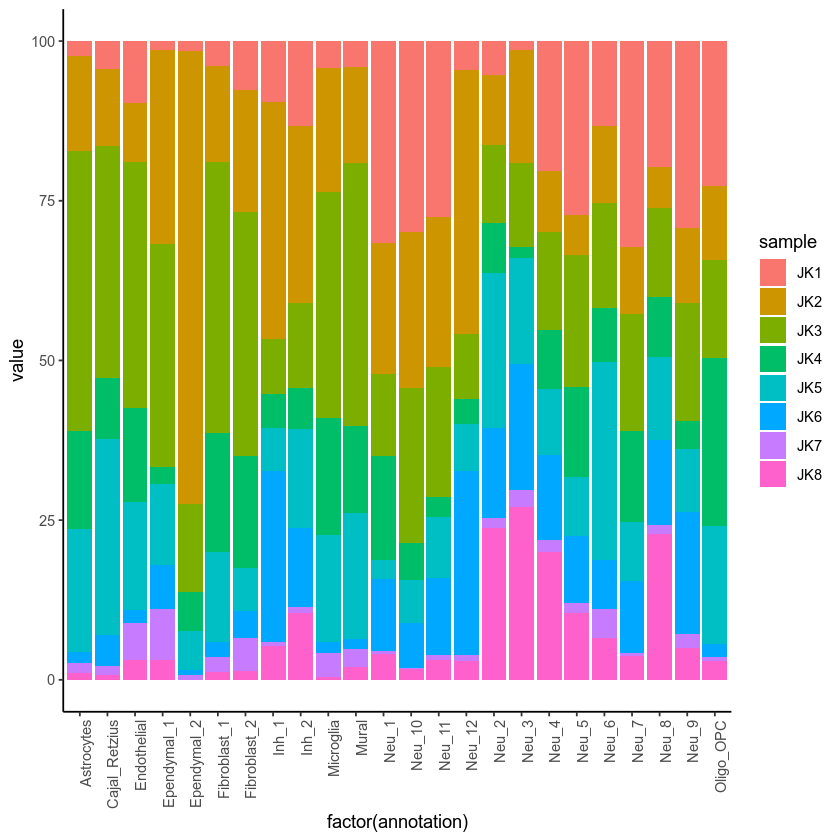

In [32]:
distribution_table = cells@meta.data %>%
    group_by(annotation, sample) %>% select(annotation) %>% table()  

apply(distribution_table, 1, function(i) 100*i/sum(i)) %>%
      
    reshape2::melt() %>%
    ggplot(., aes(x = sample,
                 y = value,
                 fill = factor(annotation))) +
    geom_bar(stat="identity") + theme_classic()
      
apply(distribution_table, 2, function(i) 100*i/sum(i)) %>%
      
    reshape2::melt() %>%
    ggplot(., aes(fill = sample,
                 y = value,
                 x = factor(annotation))) +
    geom_bar(stat="identity") + theme_classic() + theme(axis.text.x = element_text(angle = 90, hjust =1))


The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



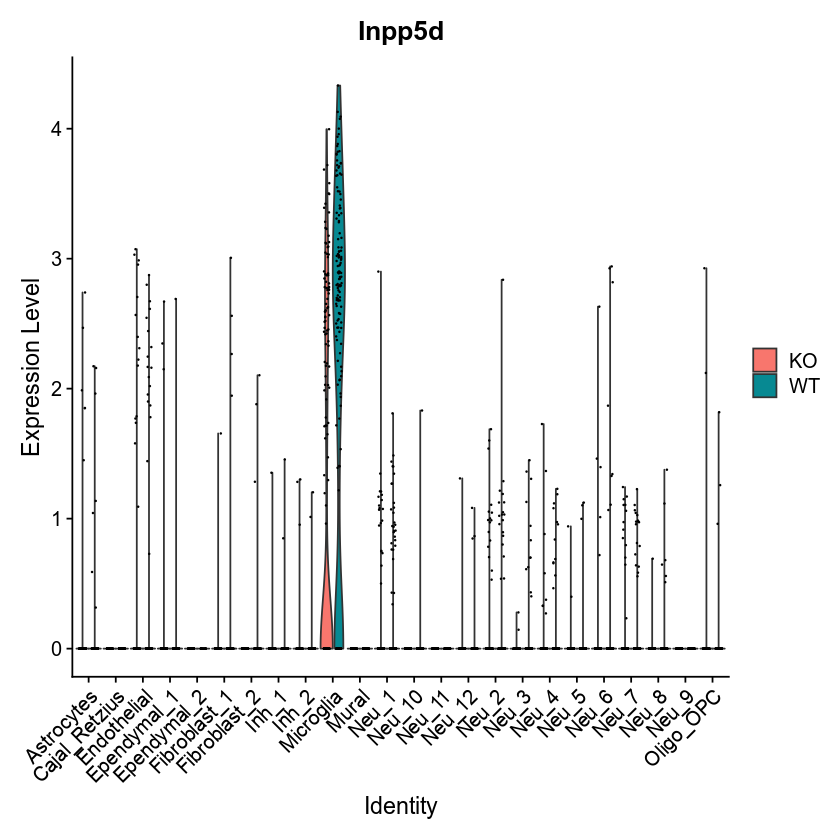

In [33]:
VlnPlot(cells,
        group.by = "annotation",
        features = "Inpp5d", split.by = "Genotype")

In [34]:
saveRDS(cells, paste0(Output.dir.objects, "allSamps_harmony_integration.rds"))


In [63]:
#highlight where each cluster is

pdf("003A Harmony Highlight Each Cluster res0.12.pdf")

for (cluster in levels(Idents(cells))){
    cells@meta.data$highlight_label <- cells@meta.data$annotation == cluster
    plot <- DimPlot(cells, reduction = 'umap', group.by = "highlight_label",
                    raster = T,
                    label = FALSE ) +
    ggtitle(paste0("Showing cluster: ", cluster))
    
    print(plot)
}

dev.off()


png 
  2

### Markers to annotate clusters

In [35]:
Sys.time()

[1] "2024-03-02 00:40:13 CET"

In [36]:
Idents(cells) = "annotation"
cluster_markers = FindAllMarkers(cells)
saveRDS(cluster_markers, "003A_cluster_markers_annotation_res0.12.rds")

Calculating cluster Neu_4

Calculating cluster Neu_5

Calculating cluster Neu_7

Calculating cluster Neu_1

Calculating cluster Oligo_OPC

Calculating cluster Neu_9

Calculating cluster Fibroblast_1

Calculating cluster Inh_1

Calculating cluster Neu_11

Calculating cluster Inh_2

Calculating cluster Neu_2

Calculating cluster Neu_8

Calculating cluster Fibroblast_2

Calculating cluster Neu_10

Calculating cluster Neu_6

Calculating cluster Astrocytes

Calculating cluster Neu_3

Calculating cluster Neu_12

Calculating cluster Cajal_Retzius

Calculating cluster Endothelial

Calculating cluster Microglia

Calculating cluster Mural

Calculating cluster Ependymal_2

Calculating cluster Ependymal_1



In [37]:
#add cluster numbers for ease of checking
align_df = cells@meta.data %>% group_by(annotation, RNA_snn_res.0.12) %>% 
    slice(1) %>% select(annotation, RNA_snn_res.0.12)

cluster_markers = cluster_markers %>% left_join(., align_df, by=c("cluster"="annotation"))
saveRDS(cluster_markers, "003A_cluster_markers_annotation_res0.12.rds")

### Plot top100 cluster markers on publicly available 10x Visium test data to help annotations

In [39]:
sample_10x = readRDS("../10x_Sample/10x_sample_visium_mouse.rds")

for (each in  sort(unique(cluster_markers$RNA_snn_res.0.12))){
    geneset = cluster_markers %>% filter(RNA_snn_res.0.12 == each) %>% filter(avg_log2FC > 0) %>% 
        arrange(-avg_log2FC) %>% slice(1:100) %>%
        .$gene
    geneset = list(geneset)
    
    sample_10x = AddModuleScore(sample_10x, features = geneset, name = paste0("Cluster_", each, "_"))
}

to_plot = colnames(sample_10x@meta.data)[grepl("Clus", colnames(sample_10x@meta.data))]

In [40]:
pdf("003A_cluster_markers_on_Visium_alpha0.8_scale1.5.pdf")

for (each in to_plot){
    
    print(SpatialFeaturePlot(object = sample_10x, features = each, alpha = 0.8, pt.size.factor = 1.5)
)
}

dev.off()


png 
  2

### Label transfer from Allen Brain Atlas object to help  annotations

In [41]:
allen <- readRDS("/data/bcn/p280287/Documents/Allen_brain_atlas_mouse/allen_mouse.rds")

DefaultAssay(allen) = "RNA"

anchors <- FindTransferAnchors(reference = allen, query = cells, dims = 1:30)
predictions <- TransferData(anchorset = anchors, refdata = allen@meta.data$label_short, dims = 1:30)
cells <- AddMetaData(cells, metadata = predictions)

saveRDS(predictions, "003A_labeltransfer_results_dataframe_allen_CTX_HPC.rds")

Performing PCA on the provided reference using 1643 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 6851 anchors

Filtering anchors

	Retained 2749 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



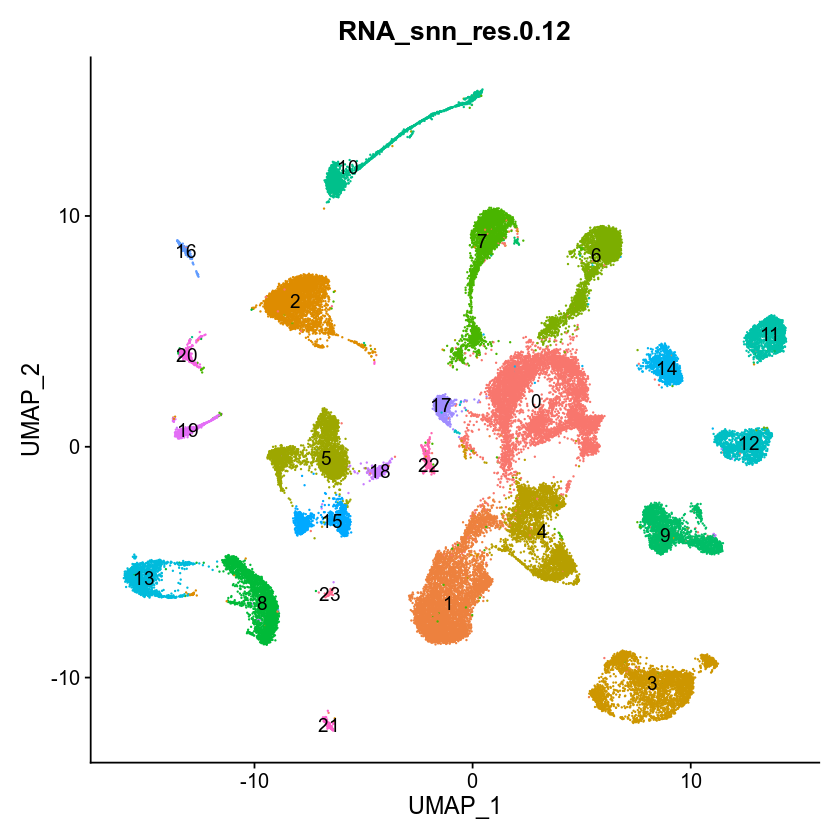

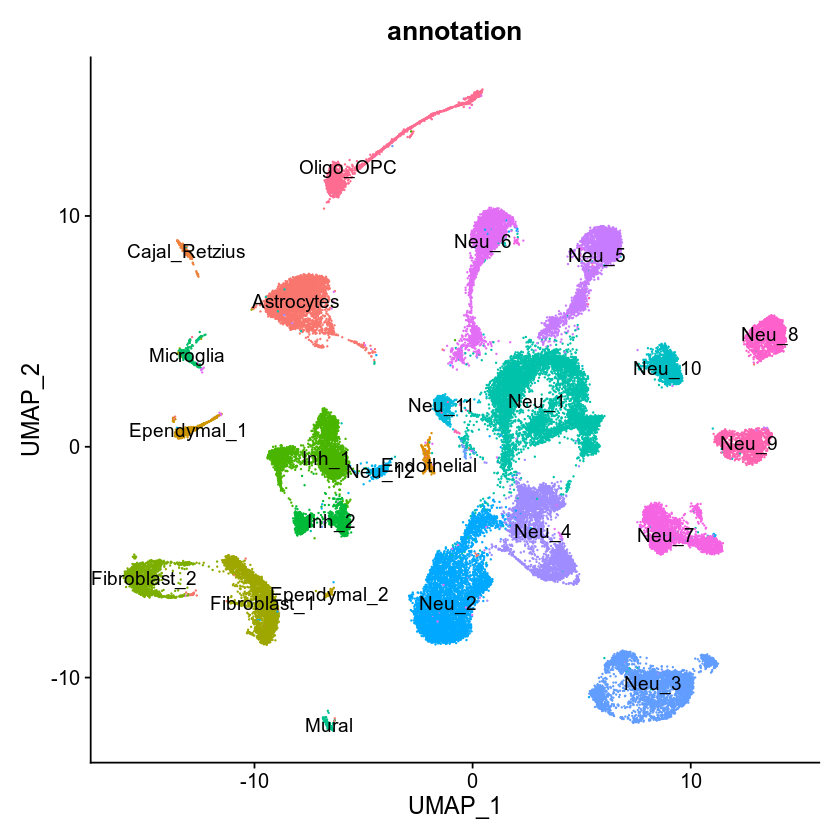

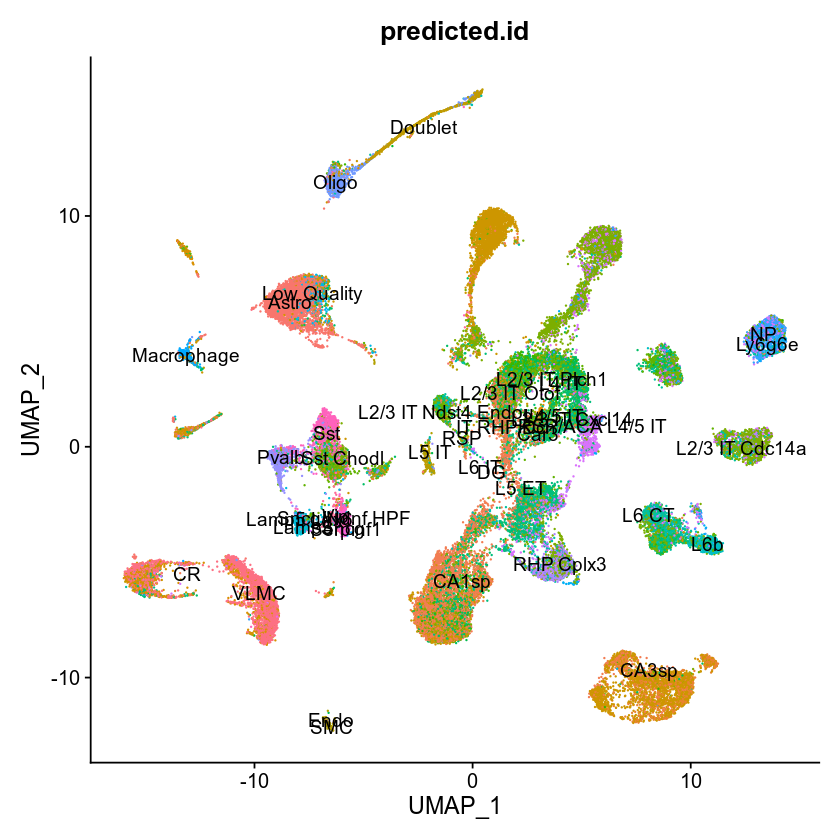

In [48]:
DimPlot(cells, group.by = "RNA_snn_res.0.12", label = T) + NoLegend()
DimPlot(cells, group.by = "annotation", label = T) + NoLegend() 
DimPlot(cells, group.by = "predicted.id", label = T) + NoLegend() 

In [43]:
colnames(cells@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "sample"                              
 [5] "SampleNumber"                        
 [6] "SampleID"                            
 [7] "UltracentrifugeRound"                
 [8] "Genotype"                            
 [9] "Sex"                                 
[10] "Age_PND"                             
[11] "StartingVolume_ul"                   
[12] "DN_cells"                            
[13] "OLIG2_cells"                         
[14] "NEUN_cells"                          
[15] "pctDN"                               
[16] "pctOLIG"                             
[17] "pctNEUN"                             
[18] "Estimate_DN_vol"                     
[19] "Estimate_OLIG2_vol"                  
[20] "Estimate_NEUN_vol"                   
[21] "Estimate_density_cells_per_ul"       
[22] "Cells_to_44k"                        
[23] "OLIG2_cells_to_add"                  
[24] "NEUN_cells_to_add"                   
[25] "OLIG2_vol_to_add"                    
[26] "NEUN_vol_to_add"                     
[27] "Total_Vol"                           
[28] "Buffer_add"                          
[29] "QC1"                                 
[30] "QC2"                                 
[31] "CellRanger_cellNum"                  
[32] "CellRanger_Avg_Counts"               
[33] "CellRanger_Median_Counts"            
[34] "CellRanger_Saturation"               
[35] "cell_id"                             
[36] "doublet_scores"                      
[37] "predicted_doublets"                  
[38] "percent.mito"                        
[39] "percent.ribo"                        
[40] "RNA_snn_res.0.1"                     
[41] "seurat_clusters"                     
[42] "RNA_snn_res.0.12"                    
[43] "annotation"                          
[44] "predicted.id"                        
[45] "prediction.score.L5.ET"              
[46] "prediction.score.L5.IT"              
[47] "prediction.score.L4.5.IT"            
[48] "prediction.score.L4.IT"              
[49] "prediction.score.L6.CT"              
[50] "prediction.score.L6.IT"              
[51] "prediction.score.NP"                 
[52] "prediction.score.Pvalb"              
[53] "prediction.score.Vip"                
[54] "prediction.score.L2.3.IT.Otof"       
[55] "prediction.score.Lamp5"              
[56] "prediction.score.Sst"                
[57] "prediction.score.Oligo"              
[58] "prediction.score.Doublet"            
[59] "prediction.score.Sst.Chodl"          
[60] "prediction.score.Car3"               
[61] "prediction.score.Sncg"               
[62] "prediction.score.Lamp5.Lhx6"         
[63] "prediction.score.Serpinf1"           
[64] "prediction.score.Astro"              
[65] "prediction.score.L6b"                
[66] "prediction.score.Endo"               
[67] "prediction.score.L2.3.IT.Cxcl14"     
[68] "prediction.score.Meis2"              
[69] "prediction.score.Macrophage"         
[70] "prediction.score.CR"                 
[71] "prediction.score.Low.Quality"        
[72] "prediction.score.VLMC"               
[73] "prediction.score.RSP.ACA.L4.5.IT"    
[74] "prediction.score.PIR.Six3"           
[75] "prediction.score.SMC"                
[76] "prediction.score.Sncg.Ndnf.HPF"      
[77] "prediction.score.RSP"                
[78] "prediction.score.IT.RHP.Dcn"         
[79] "prediction.score.DG"                 
[80] "prediction.score.CA1sp"              
[81] "prediction.score.CA1sp.SUB.sp.Kcnip1"
[82] "prediction.score.SUB.Sp.Ndst4"       
[83] "prediction.score.CA3sp"              
[84] "prediction.score.CA2sp.IG"           
[85] "prediction.score.Unknown"            
[86] "prediction.score.L2.3.IT.Ndst4.Endou"
[87] "prediction.score.RHP.Cplx3"          
[88] "prediction.score.L2.3.IT.Plch1"      
[89] "prediction.score.L2.3.IT.Cdc14a"     
[90] "prediction.score.POST.PRE.PAR.Ptgfr" 
[91] "prediction.score.Ly6g6e"           

### Explore markers

In [58]:
cluster_markers %>% filter(RNA_snn_res.0.12 == 22) %>% arrange(-avg_log2FC)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,RNA_snn_res.0.12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
0.000000e+00,5.304623,0.897,0.010,0.000000e+00,Endothelial,Flt1,22
0.000000e+00,5.007946,0.852,0.007,0.000000e+00,Endothelial,Mecom,22
0.000000e+00,4.298559,0.746,0.003,0.000000e+00,Endothelial,Adgrl4,22
0.000000e+00,4.269154,0.770,0.060,0.000000e+00,Endothelial,Ccdc141,22
0.000000e+00,4.223494,0.653,0.005,0.000000e+00,Endothelial,Slco1a4,22
0.000000e+00,4.078616,0.746,0.106,0.000000e+00,Endothelial,Bsg,22
0.000000e+00,4.056207,0.746,0.036,0.000000e+00,Endothelial,Ptprb,22
0.000000e+00,3.909944,0.674,0.046,0.000000e+00,Endothelial,Slc7a5,22
0.000000e+00,3.803210,0.670,0.015,0.000000e+00,Endothelial,Fli1,22


In [70]:
cluster_markers %>% filter(gene == "Chrm2") %>% arrange(-avg_log2FC)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,RNA_snn_res.0.12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
0.000000e+00,1.5646731,0.566,0.092,0.000000e+00,Neu_5,Chrm2,6
4.916449e-171,0.7684446,0.350,0.113,1.197450e-166,Neu_8,Chrm2,11
1.316684e-06,0.6875636,0.184,0.119,3.206916e-02,Neu_12,Chrm2,18
1.757336e-135,0.5630333,0.254,0.111,4.280168e-131,Inh_1,Chrm2,5
3.781952e-98,0.3834531,0.303,0.115,9.211323e-94,Neu_9,Chrm2,12
2.788329e-34,-0.3401914,0.032,0.124,6.791253e-30,Oligo_OPC,Chrm2,10
1.920150e-03,-0.4136629,0.031,0.120,1.000000e+00,Ependymal_2,Chrm2,23
3.577153e-04,-0.4174192,0.074,0.121,1.000000e+00,Neu_11,Chrm2,17
5.771280e-11,-0.4271836,0.017,0.121,1.405653e-06,Microglia,Chrm2,20


### Annotations based on markers, spatial plots, and labelTransfer

In [44]:
labelTransfer = cells@meta.data$predicted.id %>% unique() %>% sort()
labelTransfer

[1] "Astro"               "CA1sp"               "CA3sp"              
 [4] "Car3"                "CR"                  "DG"                 
 [7] "Doublet"             "Endo"                "IT RHP Dcn"         
[10] "L2/3 IT Cdc14a"      "L2/3 IT Cxcl14"      "L2/3 IT Ndst4 Endou"
[13] "L2/3 IT Otof"        "L2/3 IT Plch1"       "L4 IT"              
[16] "L4/5 IT"             "L5 ET"               "L5 IT"              
[19] "L6 CT"               "L6 IT"               "L6b"                
[22] "Lamp5"               "Lamp5 Lhx6"          "Low Quality"        
[25] "Ly6g6e"              "Macrophage"          "NP"                 
[28] "Oligo"               "Pvalb"               "RHP Cplx3"          
[31] "RSP"                 "RSP/ACA L4/5 IT"     "Serpinf1"           
[34] "SMC"                 "Sncg"                "Sncg/Ndnf HPF"      
[37] "Sst"                 "Sst Chodl"           "Vip"                
[40] "VLMC"

In [45]:
pdf("003A_labelTransfer_DimPlots.pdf")

for (each in labelTransfer){
    cells@meta.data$highlight = cells@meta.data$predicted.id == each
    
    print(DimPlot(cells, label = T, raster = T,
                  split.by = "highlight",
                  group.by = "predicted.id"
                 ) + NoLegend() + ggtitle(each)) 
}

dev.off()

png 
  2

In [46]:
Sys.time()

[1] "2024-03-02 04:23:33 CET"

In [ ]:
#tentative annotation based on prev analysis (need markers to confirm)
cells$annotation2 = case_when(cells$RNA_snn_res.0.12 == 0 ~ "Neu_1", #Neu_1
                             cells$RNA_snn_res.0.12 == 1 ~ "Neu_2", #Neu_2
                             cells$RNA_snn_res.0.12 == 2 ~ "Astrocytes", 
                             cells$RNA_snn_res.0.12 == 3 ~ "Neu_3", #Neu_3
                             cells$RNA_snn_res.0.12 == 4 ~ "Neu_4", #Neu_4
                             cells$RNA_snn_res.0.12 == 5 ~ "Inh_MGE", 
                             cells$RNA_snn_res.0.12 == 6 ~ "Neu_5", #Neu_5
                             cells$RNA_snn_res.0.12 == 7 ~ "Neu_DG", #Neu6, Prox1
                             cells$RNA_snn_res.0.12 == 8 ~ "Fibroblast_1", 
                             cells$RNA_snn_res.0.12 == 9 ~ "Neu_7", #Neu_7
                             cells$RNA_snn_res.0.12 == 10 ~ "Oligo_OPC", 
                             cells$RNA_snn_res.0.12 == 11 ~ "Neu_8", #Neu_8
                             cells$RNA_snn_res.0.12 == 12 ~ "Neu_9", #Neu_9
                             cells$RNA_snn_res.0.12 == 13 ~ "Fibroblast_2",
                             cells$RNA_snn_res.0.12 == 14 ~ "Neu_10",#Neu_10
                             cells$RNA_snn_res.0.12 == 15 ~ "Inh_CGE",
                             cells$RNA_snn_res.0.12 == 16 ~ "Cajal_Retzius",
                             cells$RNA_snn_res.0.12 == 17 ~ "Neu_11",#Neu_11
                             cells$RNA_snn_res.0.12 == 18 ~ "Neu_12",#Neu_12
                             cells$RNA_snn_res.0.12 == 19 ~ "Ependymal_1",
                             cells$RNA_snn_res.0.12 == 20 ~ "Microglia",
                             cells$RNA_snn_res.0.12 == 21 ~ "Mural",
                             cells$RNA_snn_res.0.12 == 22 ~ "Endothelial",
                             cells$RNA_snn_res.0.12 == 23 ~ "Ependymal_2"
                             
                             
                            )

DimPlot(cells, group.by = "annotation2", label =T) +NoLegend()

In [ ]:
saveRDS(cells, paste0(Output.dir.objects, "allSamps_harmony_integration.rds"))


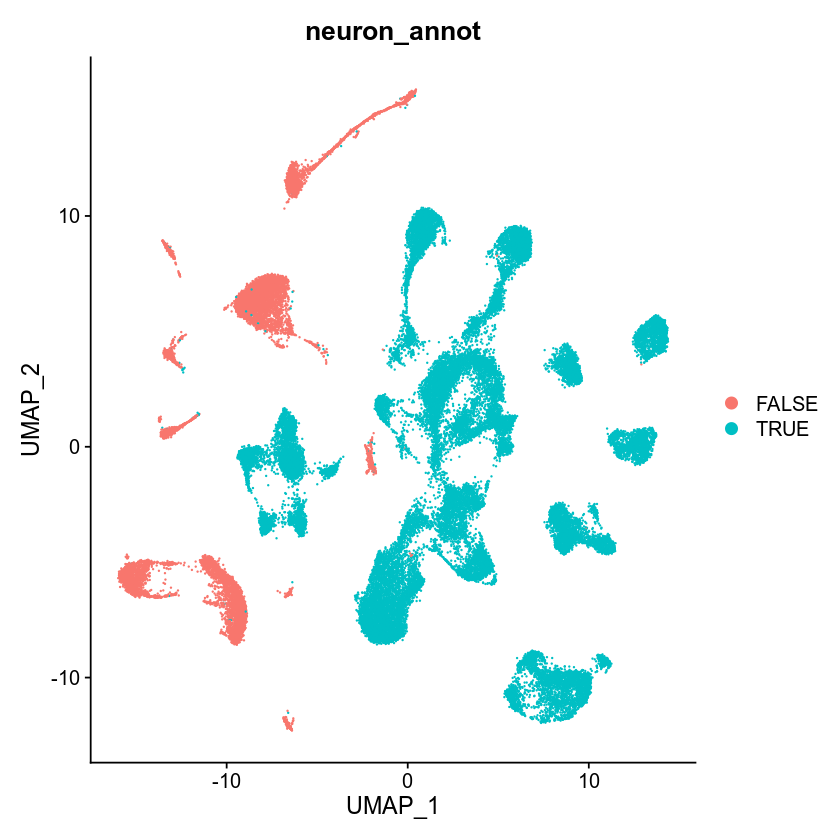

In [73]:
#define neuronal nuclei
cells@meta.data$neuron_annot =  grepl("Neu", cells@meta.data$annotation) | cells@meta.data$annotation %in% c("Inh_1", "Inh_2")
DimPlot(cells, group.by = 'neuron_annot')

#neuron_subset = subset(cells, neuron_annot == TRUE)

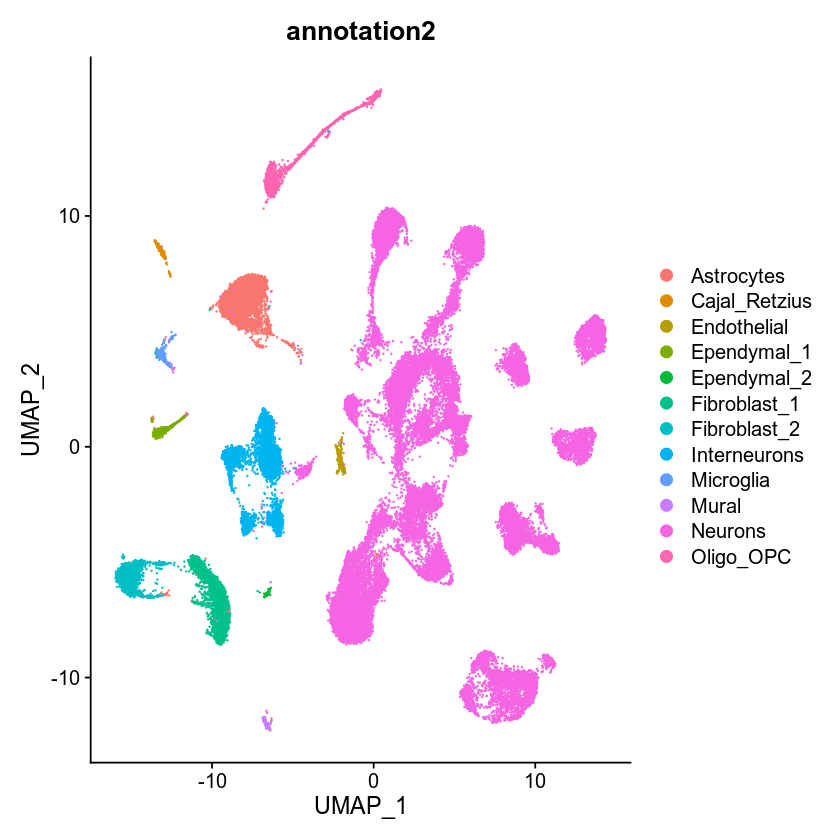

In [74]:
cells@meta.data$annotation2 = case_when(cells@meta.data$annotation %in% c("Inh_1", "Inh_2") ~ "Interneurons",
                                        cells@meta.data$neuron_annot == TRUE ~ "Neurons",
                                        T ~ cells@meta.data$annotation
                                        )
                              
DimPlot(cells, group.by = 'annotation2')


In [77]:
saveRDS(cells, paste0(Output.dir.objects, "allSamps_harmony_integration.rds"))


### Proceed to re-clustering with non-neuronal cells (003B) and neuronal cells (003C)